# Uniform Trajectory

In [3]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [4]:
from jax import config
config.update("jax_enable_x64", True)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

In [7]:
from emmd.utils import grid, bin_data
from emmd.mmd import ImpCloudMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK 
from emmd.kernels import RFF
from emmd.train import trainable, train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.score import ScoreDensity

In [8]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [9]:
key = jax.random.PRNGKey(0)

## Data

In [10]:
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

In [103]:
lb =  jnp.array([0.14,0.15])
ub =  jnp.array([0.91,0.9])
bounds = jnp.array([lb, ub])
uni_pdf = lambda x: 1 / jnp.prod(ub - lb) 

X_grid = grid(bounds, N=100, flatten=False)
X_flat = grid(bounds, N=100)
prob_X_flat = jax.vmap(uni_pdf)(X_flat)

n_traj = 100
samples = grid(bounds, N=20)
sample_grid = grid(bounds, N=20, flatten=False)
prob_s = jax.vmap(uni_pdf)(samples)

traj_init = jnp.linspace(lb, ub, num=n_traj, endpoint=True)
# traj_init = jax.random.choice(key, samples, shape=(n_traj,), replace=False)

### Initial Plot

In [28]:
pdf_recon_init = ergodic_metric(traj_init, bounds, n_modes=20, n_per_dim=100)
pdf_true = jax.vmap(uni_pdf)(X_grid)

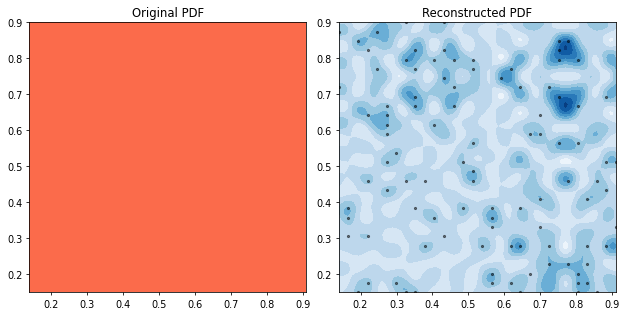

In [37]:
# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Original PDF')
ax.contourf(X_grid[:, :, 0], X_grid[:,:, 1], pdf_true.reshape(100, 100), cmap='Reds')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Reconstructed PDF')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], pdf_recon_init.reshape(100, 100), cmap='Blues')
ax.scatter(traj_init[:,0], traj_init[:,1], c='k', s=5, alpha=0.5)

plt.show()
plt.close()

## Model Definitions

In [104]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=tuple(range(d))))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [90]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            model_trained, model_loss = train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

            return model_trained, model_loss

    else:
        def training_fn(model):
            model_trained, model_loss = train_mmd(
                key, model, samples, bounds, aux_loss=traj_loss_fn, 
                opt_params=solver_params
            )

            return model_trained, model_loss

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [91]:
epochs_k = 2000
epochs_mmd = 1000
lr = 1e-3

### RBF

In [92]:
power_params = {'epochs': epochs_k, 'lr': lr}
gp_params = {
    "epochs": epochs_k, 'diag': 1e-3, 'lr': lr, 'verbose': False
}
score_params = {
    'mu': jnp.ones(2) * 0.5, 'sigma': jnp.ones(2) * 4, 'lr': 1e-4,
    'epochs': epochs_k, 'verbose': True
}

Train kernels:

In [93]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples, prob_s, bounds, power_params, gp_params, score_params
)

Training power
Training gp
Training score
epoch 0,loss: -3.341566152981828
epoch 50,loss: -3.23038979261612
epoch 100,loss: -3.2766831011143234
epoch 150,loss: -3.3524304467019492
epoch 200,loss: -3.476686929489227
epoch 250,loss: -3.277771601818553
epoch 300,loss: -3.209412565374076
epoch 350,loss: -3.7120249031427943
epoch 400,loss: -3.530751669600274
epoch 450,loss: -3.5582193164172264
epoch 500,loss: -3.548360093098676
epoch 550,loss: -3.8562799413084874
epoch 600,loss: -3.6776368654848723
epoch 650,loss: -3.6038880806527267
epoch 700,loss: -3.7548799157090342
epoch 750,loss: -3.6388378958522174
epoch 800,loss: -3.7319544252292935
epoch 850,loss: -3.744089505591512
epoch 900,loss: -3.751608935956805
epoch 950,loss: -3.8818072070855245
epoch 1000,loss: -3.7322505692510095
epoch 1050,loss: -3.849651661427204
epoch 1100,loss: -3.8056417825972915
epoch 1150,loss: -3.8412506401378836
epoch 1200,loss: -3.5654836453757652
epoch 1250,loss: -3.7093638798886293
epoch 1300,loss: -3.7475225108

Train trajectories with MMD:

In [94]:
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples, bounds, traj_loss_fn,
        solver_params={'tol': 1e-4, 'maxiter': 10_000}, use_adam=False
)

Training model 1
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 1.220052757917628e-05 Stepsize:1.0  Decrease Error:0.0  Curvature Error:1.220052757917628e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 3.3906537265275885e-06 Stepsize:1.0  Decrease Error:0.0  Curvature Error:3.3906537265275885e-06 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 4.135997969502924e-05 Stepsize:1.0  Decrease Error:0.0  Curvature Error:4.135997969502924e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 3.5290516337470754e-06 Stepsize:1.0  Decrease Error:0.0  Curvature Error:3.5290516337470754e-06 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 3.6877269234

In [98]:
for model in rbf_models:
    print(model.k.transform._scale)

[0.24315789 0.23684211]
[0.17245951 0.1704299 ]
[0.9719826  0.95610177]
[0.38609446 0.35960322]


Visualize the probability surfaces of the gp and score predictions

In [95]:
gp_preds = gp_pred(rbf_gp.k, samples, prob_s, X_flat)[0]
gp_preds = gp_preds.reshape(100, 100)

z = jax.random.choice(key, samples, shape=(100,), replace=False)
score = ScoreDensity(key, rbf_score.k, z)
score_preds = jnp.exp(score.log_density(X_flat))
score_preds = score_preds.reshape(100, 100)

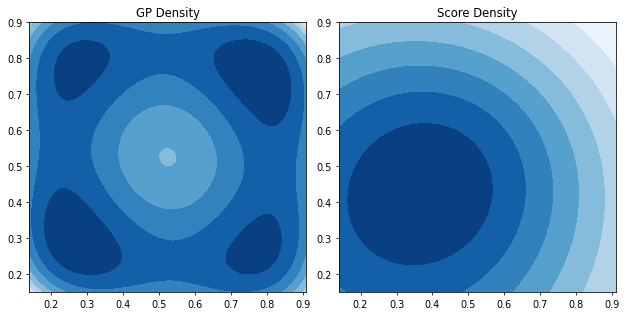

In [99]:
# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('GP Density')
ax.contourf(X_grid[:, :, 0], X_grid[:,:, 1], gp_preds, cmap='Blues')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Score Density')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], score_preds, cmap='Blues')

plt.show()
plt.close()

Visualize trajectories:

<Axes: >

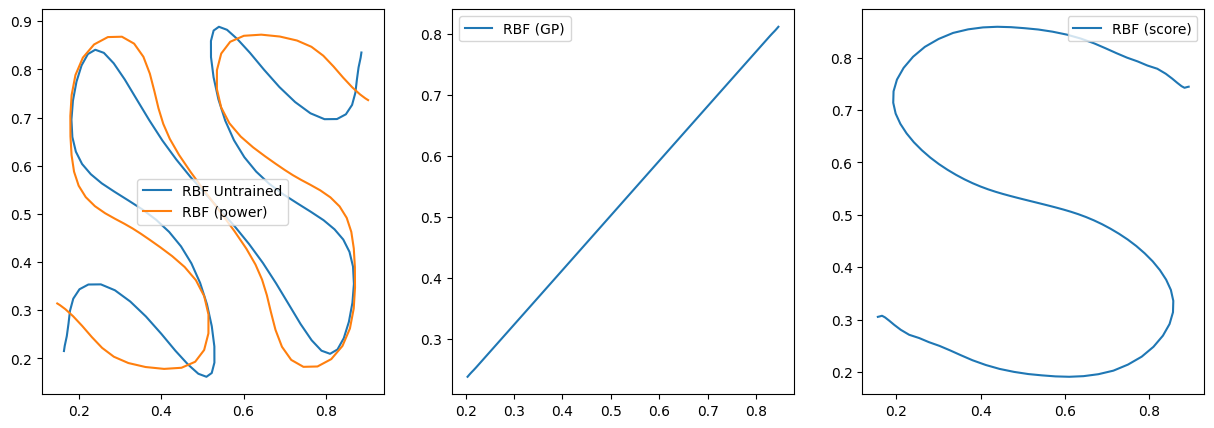

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.scatterplot(x=samples[:, 0], y=samples[:,1], ax=ax[0])

sns.lineplot(
    x=rbf_traj_init.w[:, 0], y=rbf_traj_init.w[:,1], label="RBF Untrained", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_power_traj.w[:, 0], y=rbf_power_traj.w[:,1], label="RBF (power)", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_gp_traj.w[:, 0], y=rbf_gp_traj.w[:,1], label="RBF (GP)", 
    ax=ax[1], sort=False
)
sns.lineplot(
    x=rbf_score_traj.w[:, 0], y=rbf_score_traj.w[:,1], label="RBF (score)", 
    ax=ax[2], sort=False
)

## Metrics

In [105]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [122]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=100)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=100)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=100)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=100)

In [123]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(28.25934436, dtype=float64),
 Array(29.97701283, dtype=float64),
 Array(192.97166348, dtype=float64),
 Array(48.23838574, dtype=float64))

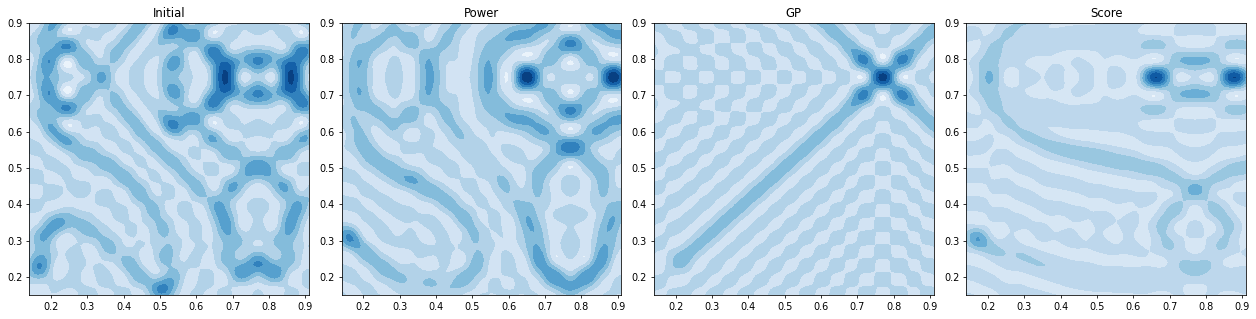

In [124]:
# visualize for comparison
fig, axes = plt.subplots(1, 4, figsize=(18,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Initial')
ax.contourf(X_grid[:, :, 0], X_grid[:,:, 1], rbf_init_erg.reshape(100,100), cmap='Blues')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Power')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], rbf_power_erg.reshape(100,100), cmap='Blues')

ax = axes[2]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('GP')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], rbf_gp_erg.reshape(100,100), cmap='Blues')

ax = axes[3]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Score')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], rbf_score_erg.reshape(100,100), cmap='Blues')

plt.show()
plt.close()